# Taxi Ride Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('cleaned_data_20230424-1.csv')
df = df.fillna(0)

In [3]:
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
df = df[(df.index >= '2020-04-01')]
df = df.drop(['Rideshare_trips'], axis=1)
df.head()

,Taxi_trips,Arr Pax,Temp (°C),Rel Hum (%),Wind Spd (km/h),Freezing Drizzle,Rain,Smoke,Heavy Rain,Haze,...,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1_excel,lag2_excel,lag3_excel
datetime,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:00:00,4,0.0,5.0,84.0,16.0,0,0,0,0,0,...,2,2,4,2020,92,1,14,43558.000000,43194.000000,42830.000000
2020-04-01 01:00:00,2,0.0,5.0,84.0,13.0,0,0,0,0,0,...,2,2,4,2020,92,1,14,43558.041667,43194.041667,42830.041667
2020-04-01 02:00:00,1,0.0,4.3,89.0,15.0,0,0,0,0,0,...,2,2,4,2020,92,1,14,43558.083333,43194.083333,42830.083333
2020-04-01 03:00:00,1,0.0,3.3,94.0,16.0,0,1,0,0,0,...,2,2,4,2020,92,1,14,43558.125000,43194.125000,42830.125000
2020-04-01 04:00:00,2,0.0,2.7,93.0,15.0,0,0,0,0,0,...,2,2,4,2020,92,1,14,43558.166667,43194.166667,42830.166667


We've created the dummy variables for region and weather in the cleaning step already. Also, we separated the date into `hour`, `dayofweek`, `quarter`, `month`, `year`, `dayofyear`, `dayofmonth`, and `weekofyear`. Also, we added lag features, `lag1_excel`, `lag2_excel`, and `lag3_excel`, to capture the flow of time.

We came up with one more feature, which is season. We set winter as 1, spring as 2, and so on.

In [4]:
def season(df):
    """
    Create season features based on month.
    """
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    month_to_season = dict(zip(range(1, 13), seasons))
    df['season'] = df['month'].map(month_to_season)

    return df

df = season(df)

In [5]:
df.head()

,Taxi_trips,Arr Pax,Temp (°C),Rel Hum (%),Wind Spd (km/h),Freezing Drizzle,Rain,Smoke,Heavy Rain,Haze,...,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1_excel,lag2_excel,lag3_excel,season
datetime,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:00:00,4,0.0,5.0,84.0,16.0,0,0,0,0,0,...,2,4,2020,92,1,14,43558.000000,43194.000000,42830.000000,2
2020-04-01 01:00:00,2,0.0,5.0,84.0,13.0,0,0,0,0,0,...,2,4,2020,92,1,14,43558.041667,43194.041667,42830.041667,2
2020-04-01 02:00:00,1,0.0,4.3,89.0,15.0,0,0,0,0,0,...,2,4,2020,92,1,14,43558.083333,43194.083333,42830.083333,2
2020-04-01 03:00:00,1,0.0,3.3,94.0,16.0,0,1,0,0,0,...,2,4,2020,92,1,14,43558.125000,43194.125000,42830.125000,2
2020-04-01 04:00:00,2,0.0,2.7,93.0,15.0,0,0,0,0,0,...,2,4,2020,92,1,14,43558.166667,43194.166667,42830.166667,2


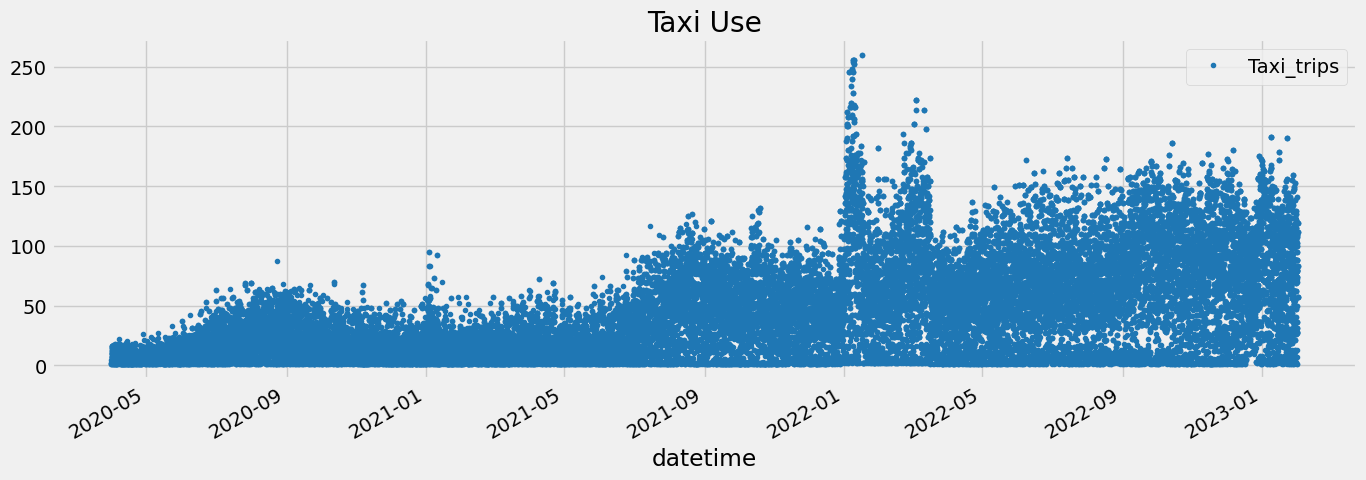

In [6]:
df.plot(y='Taxi_trips',
        style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Taxi Use')
plt.show()

# Building the Model and Choosing Algorithms

Let's try three different models: MLP Regressor, Random Forest and XGBoost. We will use data upto October 2022 as a training set, and from November 2022 to January 2023 as a test set. To choose better model, we'll compare the RMSE of each model.

In [7]:
# Train Test Split
train = df.loc[df.index < "2022-11-01"]
test = df.loc[df.index >= "2022-11-01"]

FEATURES = df.columns.drop(['Taxi_trips'])
TARGET = 'Taxi_trips'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Random Forest

In [8]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [9]:
test['forest_pred'] = rf.predict(X_test)

test

/var/folders/fb/xrsfly253nq42mq1z1k2hnc80000gn/T/ipykernel_42603/1721496839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forest_pred'] = rf.predict(X_test)


,Taxi_trips,Arr Pax,Temp (°C),Rel Hum (%),Wind Spd (km/h),Freezing Drizzle,Rain,Smoke,Heavy Rain,Haze,...,month,year,dayofyear,dayofmonth,weekofyear,lag1_excel,lag2_excel,lag3_excel,season,forest_pred
datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:00:00,71,107.0,5.0,100.0,9.0,0,0,0,0,0,...,11,2022,305,1,44,44502.000000,44138.000000,43774.000000,4,82.05
2022-11-01 00:00:00,71,111.0,5.0,100.0,9.0,0,0,0,0,0,...,11,2022,305,1,44,44502.000000,44138.000000,43774.000000,4,81.95
2022-11-01 01:00:00,16,71.0,4.2,100.0,1.0,0,0,0,0,0,...,11,2022,305,1,44,44502.041667,44138.041667,43774.041667,4,45.36
2022-11-01 02:00:00,2,0.0,4.2,100.0,9.0,0,0,0,0,0,...,11,2022,305,1,44,44502.083333,44138.083333,43774.083333,4,6.71
2022-11-01 04:00:00,1,0.0,3.2,100.0,8.0,0,0,0,0,0,...,11,2022,305,1,44,44502.166667,44138.166667,43774.166667,4,7.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 22:00:00,112,454.0,0.2,100.0,7.0,0,0,0,0,0,...,1,2023,31,31,5,44593.916667,44229.916667,43865.916667,1,117.86
2023-01-31 22:00:00,112,789.0,0.2,100.0,7.0,0,0,0,0,0,...,1,2023,31,31,5,44593.916667,44229.916667,43865.916667,1,121.10
2023-01-31 23:00:00,83,66.0,0.2,100.0,7.0,0,0,0,0,0,...,1,2023,31,31,5,44593.958333,44229.958333,43865.958333,1,71.23


## XGBoost

In [10]:
boost = xgb.XGBRegressor(base_score=0.3,
                         booster='gbtree',    
                         n_estimators=800,
                         objective='reg:linear',
                         max_depth=3,
                         learning_rate=0.005)

boost.fit(X_train, y_train,
          eval_set=[(X_train, y_train)],
          verbose=100)

[23:19:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:62.21995
[100]	validation_0-rmse:42.01962
[200]	validation_0-rmse:30.98083
[300]	validation_0-rmse:25.43361
[400]	validation_0-rmse:22.68528
[500]	validation_0-rmse:21.18171
[600]	validation_0-rmse:20.23673
[700]	validation_0-rmse:19.57410
[799]	validation_0-rmse:19.11880


XGBRegressor(base_score=0.3, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [11]:
test['boost_pred'] = boost.predict(X_test)

test

/var/folders/fb/xrsfly253nq42mq1z1k2hnc80000gn/T/ipykernel_42603/1431235999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['boost_pred'] = boost.predict(X_test)


,Taxi_trips,Arr Pax,Temp (°C),Rel Hum (%),Wind Spd (km/h),Freezing Drizzle,Rain,Smoke,Heavy Rain,Haze,...,year,dayofyear,dayofmonth,weekofyear,lag1_excel,lag2_excel,lag3_excel,season,forest_pred,boost_pred
datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:00:00,71,107.0,5.0,100.0,9.0,0,0,0,0,0,...,2022,305,1,44,44502.000000,44138.000000,43774.000000,4,82.05,48.352612
2022-11-01 00:00:00,71,111.0,5.0,100.0,9.0,0,0,0,0,0,...,2022,305,1,44,44502.000000,44138.000000,43774.000000,4,81.95,48.398109
2022-11-01 01:00:00,16,71.0,4.2,100.0,1.0,0,0,0,0,0,...,2022,305,1,44,44502.041667,44138.041667,43774.041667,4,45.36,25.979977
2022-11-01 02:00:00,2,0.0,4.2,100.0,9.0,0,0,0,0,0,...,2022,305,1,44,44502.083333,44138.083333,43774.083333,4,6.71,11.441567
2022-11-01 04:00:00,1,0.0,3.2,100.0,8.0,0,0,0,0,0,...,2022,305,1,44,44502.166667,44138.166667,43774.166667,4,7.50,11.441567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 22:00:00,112,454.0,0.2,100.0,7.0,0,0,0,0,0,...,2023,31,31,5,44593.916667,44229.916667,43865.916667,1,117.86,104.754860
2023-01-31 22:00:00,112,789.0,0.2,100.0,7.0,0,0,0,0,0,...,2023,31,31,5,44593.916667,44229.916667,43865.916667,1,121.10,104.664673
2023-01-31 23:00:00,83,66.0,0.2,100.0,7.0,0,0,0,0,0,...,2023,31,31,5,44593.958333,44229.958333,43865.958333,1,71.23,91.087662


Let's compare the RMSE of each model.

In [12]:
rf_RMSE = mean_squared_error(test['Taxi_trips'], test['forest_pred']) ** 1/2
rf_RMSE

382.7951738376127

In [13]:
XGboost_RMSE = mean_squared_error(test['Taxi_trips'], test['boost_pred']) ** 1/2
XGboost_RMSE

452.67958202993736

It looks like Random Forest model worked better than XGBoost. Let's tune the hyperparameters for Random Forest model to improve the performance.

## Hyperparameter Tuning

Let's find better combination of hyperparamters using `RandomizedSearch` and 5-fold cross validation.

In [14]:
# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(50, 100, 10),
           "min_samples_leaf": np.arange(1, 10, 2),
           "min_samples_split": np.arange(10, 20, 2),
           "max_features": [0.5, 1],
           "max_samples": [None, 5000, 10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=300,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=300,
                   param_distributions={'max_features': [0.5, 1],
                                        'max_samples': [None, 5000, 10000],
                                        'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                        'min_samples_split': array([10, 12, 14, 16, 18]),
                                        'n_estimators': array([50, 60, 70, 80, 90])},
                   verbose=True)

In [15]:
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 14,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5}

In [16]:
rf_tuned = RandomForestRegressor(n_jobs=-1, 
                                 random_state=42,
                                 n_estimators=60,
                                 min_samples_split=14,
                                 min_samples_leaf=5,
                                 max_samples=10000,
                                 max_features=0.5)

In [17]:
rf_tuned.fit(X_train, y_train)
test['forest_tuned'] = rf_tuned.predict(X_test)

/var/folders/fb/xrsfly253nq42mq1z1k2hnc80000gn/T/ipykernel_42603/1135957592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forest_tuned'] = rf_tuned.predict(X_test)


In [18]:
rs_RMSE = mean_squared_error(test['Taxi_trips'], test['forest_tuned']) ** 1/2
print(f"RMSE of Random Forest Model before hyperparameter tuning: {rf_RMSE}")
print(f"RMSE of Random Forest Model after hyperparameter tuning: {rs_RMSE}")

RMSE of Random Forest Model before hyperparameter tuning: 382.7951738376127
RMSE of Random Forest Model after hyperparameter tuning: 372.0612170503126


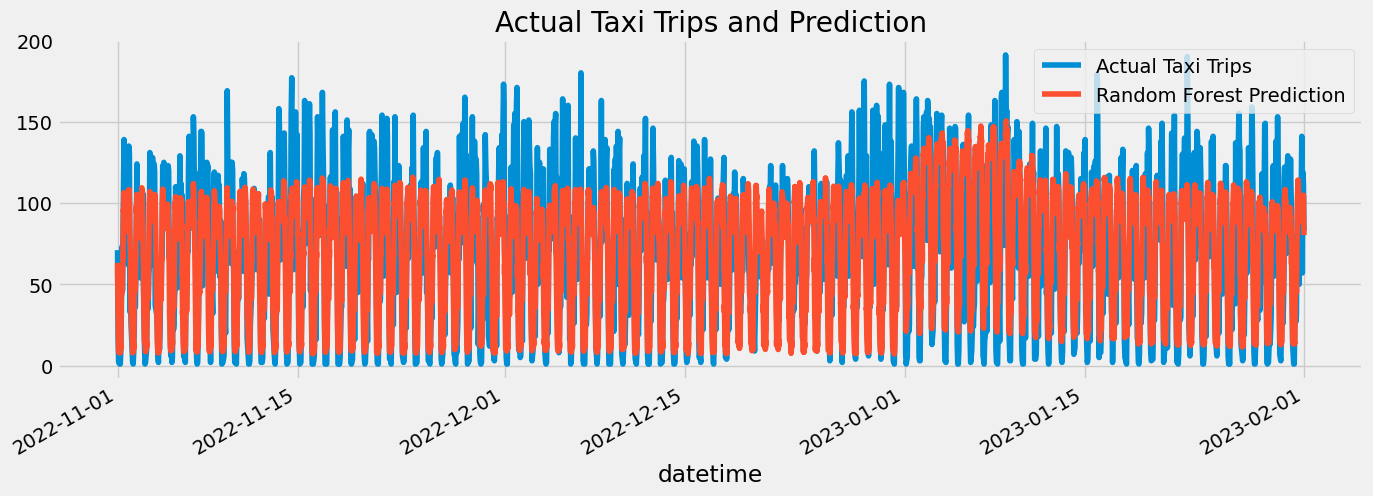

In [19]:
ax = test[['Taxi_trips']].plot(figsize=(15, 5))
test['forest_tuned'].plot(ax=ax, style='-')
plt.legend(['Actual Taxi Trips','Random Forest Prediction'])
ax.set_title('Actual Taxi Trips and Prediction')
plt.show()

It's hard to see how the models worked. Let's look into January.

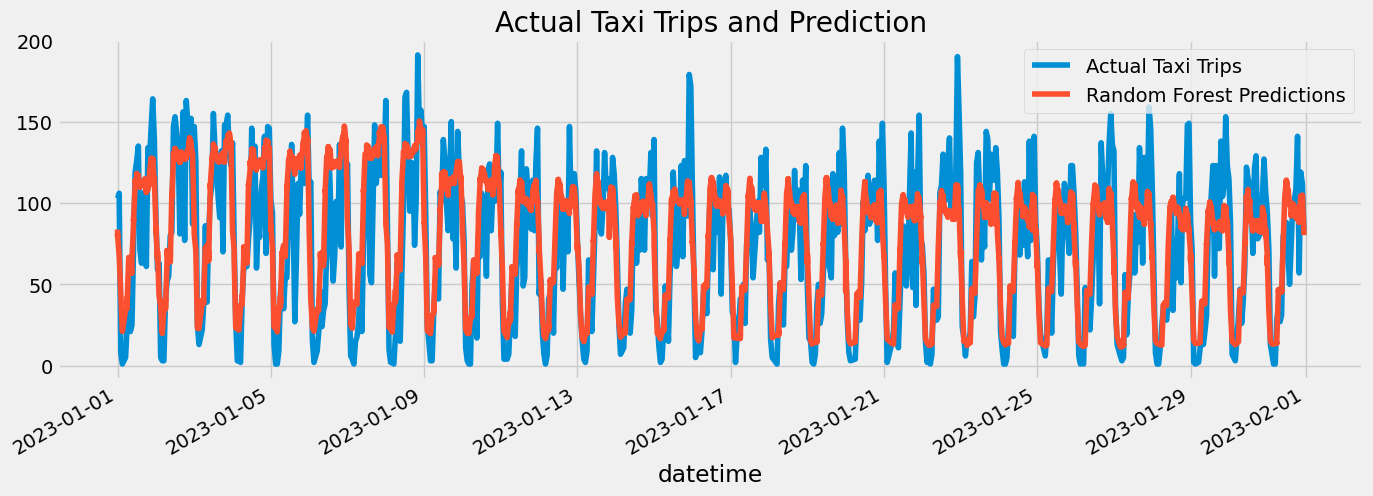

In [20]:
january = test.loc[test.index >= "2023-01-01"]

ax = january[['Taxi_trips']].plot(figsize=(15, 5))
january['forest_tuned'].plot(ax=ax, style='-')
plt.legend(['Actual Taxi Trips', 'Random Forest Predictions', 'XGBoost Predictions'])
ax.set_title('Actual Taxi Trips and Prediction')
plt.show()

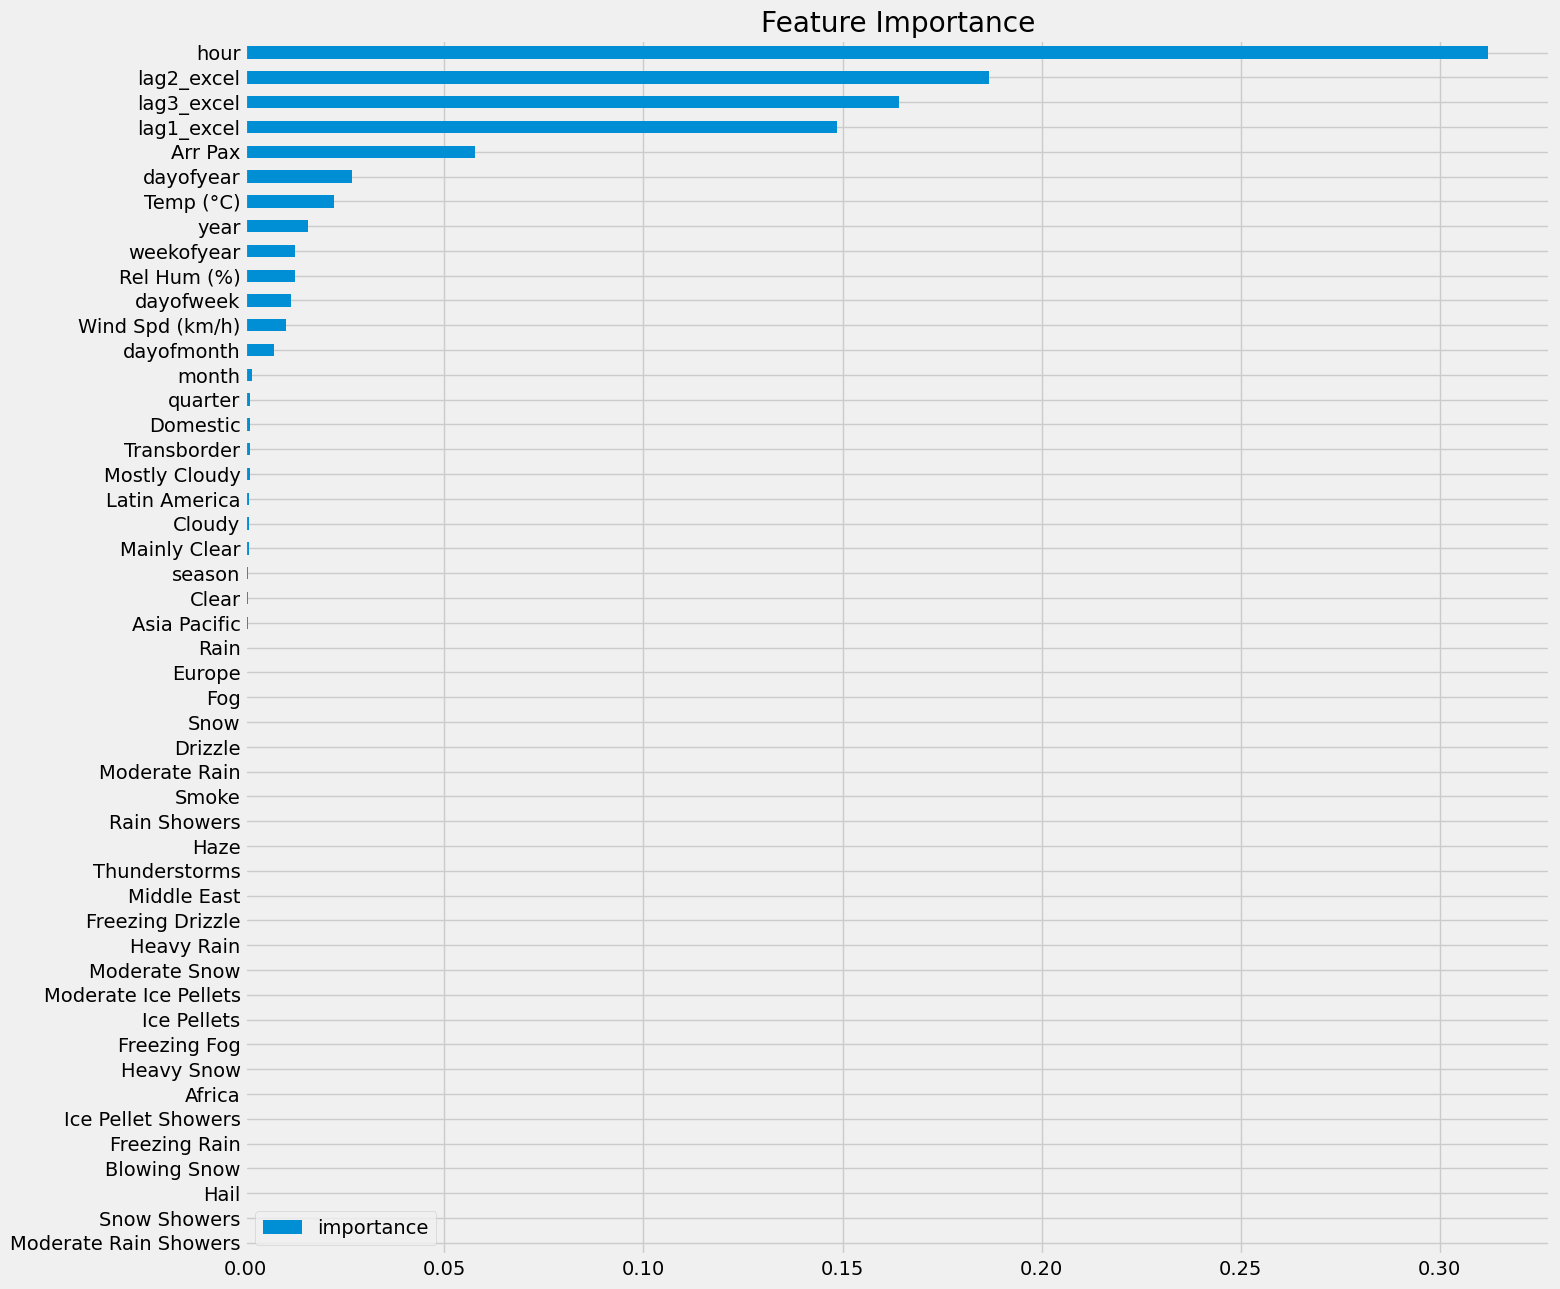

In [21]:
fi = pd.DataFrame(data=rf_tuned.feature_importances_,
                  index=rf_tuned.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 15))
plt.show()

# Future Prediction

With the model built, let's predict the future.

In [22]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

In [23]:
def season(df):
    """
    Create season features based on month.
    """
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    month_to_season = dict(zip(range(1, 13), seasons))
    df['season'] = df['month'].map(month_to_season)

    return df

In [24]:
def add_lags(df):
    df['lag1'] = df.index - pd.DateOffset(days=364)
    df['lag2'] = df.index - pd.DateOffset(days=728)
    df['lag3'] = df.index - pd.DateOffset(days=1092)
    return df

def datetime_to_excel(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])
    days_since_1899 = (df[date_column] - pd.Timestamp('1899-12-30')).dt.days
    df[date_column + '_excel'] = days_since_1899
    df.drop(columns=[date_column], inplace=True)
    return df

In [25]:
future = pd.date_range('2023-02-01', '2023-03-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
test['isFuture'] = False

test_and_future = pd.concat([test, future_df])

test_and_future = create_features(test_and_future)
test_and_future = season(test_and_future)
test_and_future = add_lags(test_and_future)
test_and_future = datetime_to_excel(test_and_future, 'lag1')
test_and_future = datetime_to_excel(test_and_future, 'lag2')
test_and_future = datetime_to_excel(test_and_future, 'lag3')

test_and_future.fillna(0, inplace=True)

test_and_future

/var/folders/fb/xrsfly253nq42mq1z1k2hnc80000gn/T/ipykernel_42603/3916426143.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['isFuture'] = False


,Taxi_trips,Arr Pax,Temp (°C),Rel Hum (%),Wind Spd (km/h),Freezing Drizzle,Rain,Smoke,Heavy Rain,Haze,...,dayofmonth,weekofyear,lag1_excel,lag2_excel,lag3_excel,season,forest_pred,boost_pred,forest_tuned,isFuture
2022-11-01 00:00:00,71.0,107.0,5.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,...,1,44,44502,44138,43774,4,82.05,48.352612,63.219346,False
2022-11-01 00:00:00,71.0,111.0,5.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,...,1,44,44502,44138,43774,4,81.95,48.398109,57.189980,False
2022-11-01 01:00:00,16.0,71.0,4.2,100.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,44,44502,44138,43774,4,45.36,25.979977,34.939110,False
2022-11-01 02:00:00,2.0,0.0,4.2,100.0,9.0,0.0,0.0,0.0,0.0,0.0,...,1,44,44502,44138,43774,4,6.71,11.441567,8.305294,False
2022-11-01 04:00:00,1.0,0.0,3.2,100.0,8.0,0.0,0.0,0.0,0.0,0.0,...,1,44,44502,44138,43774,4,7.50,11.441567,7.800489,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,9,44621,44257,43893,1,0.00,0.000000,0.000000,True
2023-02-28 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,9,44621,44257,43893,1,0.00,0.000000,0.000000,True
2023-02-28 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,9,44621,44257,43893,1,0.00,0.000000,0.000000,True
2023-02-28 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,9,44621,44257,43893,1,0.00,0.000000,0.000000,True


In [26]:
test_and_future['pred'] = rf_tuned.predict(test_and_future[FEATURES])

In [27]:
test_and_future

,Taxi_trips,Arr Pax,Temp (°C),Rel Hum (%),Wind Spd (km/h),Freezing Drizzle,Rain,Smoke,Heavy Rain,Haze,...,weekofyear,lag1_excel,lag2_excel,lag3_excel,season,forest_pred,boost_pred,forest_tuned,isFuture,pred
2022-11-01 00:00:00,71.0,107.0,5.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,...,44,44502,44138,43774,4,82.05,48.352612,63.219346,False,63.219346
2022-11-01 00:00:00,71.0,111.0,5.0,100.0,9.0,0.0,0.0,0.0,0.0,0.0,...,44,44502,44138,43774,4,81.95,48.398109,57.189980,False,57.189980
2022-11-01 01:00:00,16.0,71.0,4.2,100.0,1.0,0.0,0.0,0.0,0.0,0.0,...,44,44502,44138,43774,4,45.36,25.979977,34.939110,False,34.939110
2022-11-01 02:00:00,2.0,0.0,4.2,100.0,9.0,0.0,0.0,0.0,0.0,0.0,...,44,44502,44138,43774,4,6.71,11.441567,8.305294,False,8.305294
2022-11-01 04:00:00,1.0,0.0,3.2,100.0,8.0,0.0,0.0,0.0,0.0,0.0,...,44,44502,44138,43774,4,7.50,11.441567,7.800489,False,7.800489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,44621,44257,43893,1,0.00,0.000000,0.000000,True,72.380633
2023-02-28 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,44621,44257,43893,1,0.00,0.000000,0.000000,True,77.948606
2023-02-28 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,44621,44257,43893,1,0.00,0.000000,0.000000,True,77.155907
2023-02-28 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,44621,44257,43893,1,0.00,0.000000,0.000000,True,70.209215


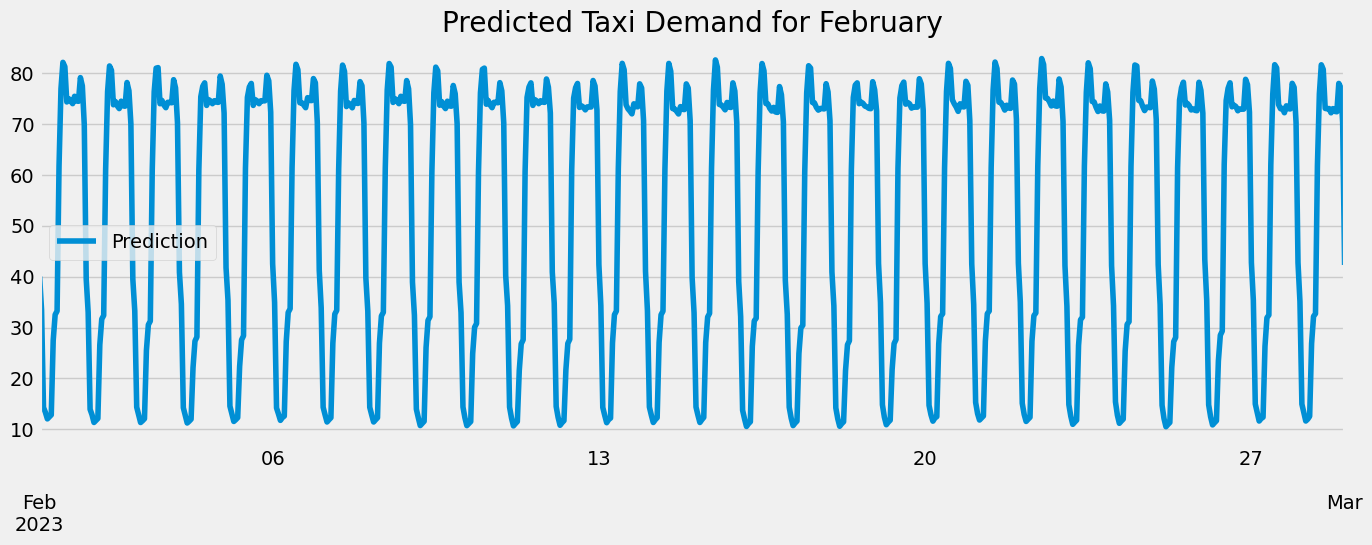

In [28]:
future = test_and_future[test_and_future['isFuture']==True]
ax = future[['pred']].plot(figsize=(15, 5))
plt.legend(['Prediction'])
ax.set_title('Predicted Taxi Demand for February')
plt.show()